In [1]:
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights

import matplotlib.pyplot as plt

In [10]:
import requests
response = requests.get('https://i.ytimg.com/vi/q71MCWAEfL8/maxresdefault.jpg')
open("obj_det.jpeg", "wb").write(response.content)

img = read_image("obj_det.jpeg")

In [11]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
# Put the model in inference mode
model.eval()
# Get the transforms for the model's weights
preprocess = weights.transforms()

In [12]:
batch = [preprocess(img)]
prediction = model(batch)[0]

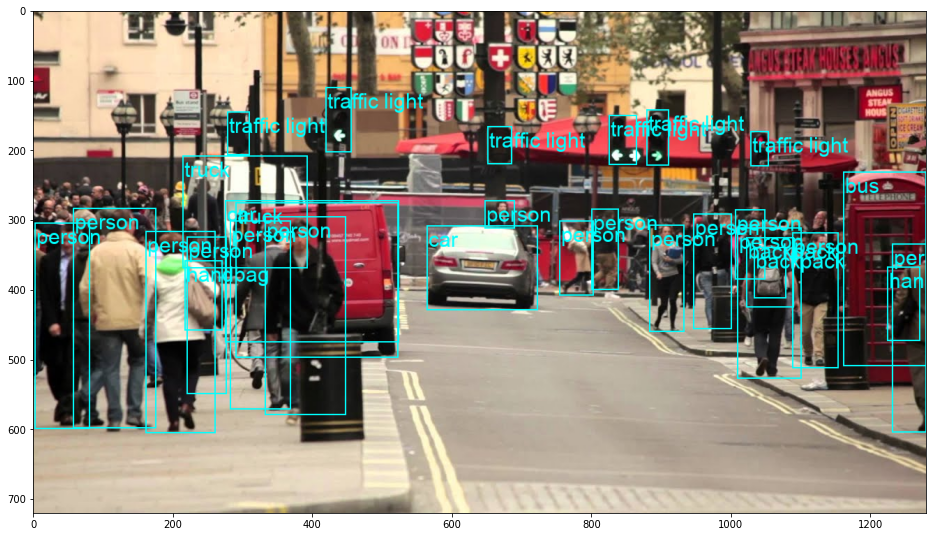

In [13]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="cyan",
                          width=2, 
                          font_size=30,
                          font='Arial')

im = to_pil_image(box.detach())

fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(im)
plt.show()

## Penn-Fudan Data

In [16]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Defining model